In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Input
from tensorflow.data import Dataset
from sklearn.model_selection import train_test_split
 


In [2]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def prep_pixels(X):
	# convert from integers to floats
	X_scaled = X.astype('float32')
	# normalize to range 0-1
	X_scaled = X_scaled / 255.0
	# return normalized images
	return X_scaled

X_train_scaled = prep_pixels(X_train)
X_valid_scaled = prep_pixels(X_valid)
X_test_scaled = prep_pixels(X_test)

y_train_enc = keras.utils.to_categorical(y_train)
y_valid_enc = keras.utils.to_categorical(y_valid)
y_test_enc = keras.utils.to_categorical(y_test)

170500096/170498071 [==============================] - 5s 0us/step


In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [4]:
model.fit(X_train_scaled, y_train_enc,
          validation_data=(X_valid_scaled, y_valid_enc),
          batch_size=64,
          epochs=20)

Epoch 1/20
625/625 [==============================] - 36s 8ms/step - loss: 1.8685 - accuracy: 0.3895 - val_loss: 1.3227 - val_accuracy: 0.5266
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 1.3890 - accuracy: 0.5098 - val_loss: 1.2475 - val_accuracy: 0.5527
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 1.2266 - accuracy: 0.5656 - val_loss: 1.1968 - val_accuracy: 0.5782
Epoch 4/20
625/625 [==============================] - 5s 7ms/step - loss: 1.1451 - accuracy: 0.5961 - val_loss: 1.1205 - val_accuracy: 0.6052
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 1.0765 - accuracy: 0.6206 - val_loss: 1.0100 - val_accuracy: 0.6478
Epoch 6/20
625/625 [==============================] - 5s 7ms/step - loss: 1.0364 - accuracy: 0.6357 - val_loss: 0.9916 - val_accuracy: 0.6482
Epoch 7/20
625/625 [==============================] - 5s 7ms/step - loss: 0.9984 - accuracy: 0.6481 - val_loss: 0.9772 - val_accuracy: 0.6520
Epoch

In [5]:
conv_model = Sequential(model.layers[:6])
conv_result = conv_model(X_train_scaled[:2])

In [6]:
conv_result_flat = tf.reshape(conv_result, [-1, 256, 32])
dense_model = Dense(1, activation='sigmoid')
attention_weight = dense_model(conv_result_flat)

In [7]:
print(conv_result_flat[0, 0])
print(attention_weight[0, 0])
print(conv_result_flat[0, 0] * attention_weight[0, 0])

tf.Tensor(
[ 0.6101958   1.7675309   0.2732088  -0.08808374  0.6980962   0.140856
 -0.0958821  -0.24492973  0.8902603   0.14766215  0.07848265  0.33896503
  0.07171553  0.7165121   1.7552495   2.8439517  -0.56945574  2.084147
 -0.64901674 -0.52015156  0.57758456 -0.24815907 -0.48694703  2.4439116
  1.7357208   1.1671839   1.6856502   1.4157997  -0.6276928  -0.6701239
 -0.18428746 -0.14565328], shape=(32,), dtype=float32)
tf.Tensor([0.45928967], shape=(1,), dtype=float32)
tf.Tensor(
[ 0.28025663  0.8118087   0.12548198 -0.04045595  0.32062837  0.0646937
 -0.04403766 -0.11249369  0.40888736  0.0678197   0.03604627  0.15568313
  0.0329382   0.3290866   0.80616796  1.3061976  -0.26154515  0.9572272
 -0.29808667 -0.23890023  0.26527864 -0.1139769  -0.22364974  1.1224633
  0.7971986   0.5360755   0.77420175  0.6502622  -0.28829283 -0.30778098
 -0.08464132 -0.06689704], shape=(32,), dtype=float32)


In [8]:
conv_result_flat * attention_weight

<tf.Tensor: shape=(2, 256, 32), dtype=float32, numpy=
array([[[ 0.28025663,  0.8118087 ,  0.12548198, ..., -0.30778098,
         -0.08464132, -0.06689704],
        [ 0.15581523,  0.54392856,  0.27219978, ..., -0.32599157,
         -0.22141238, -0.01186585],
        [ 0.23437363,  0.63534355,  0.35807088, ..., -0.09236889,
          0.53991044, -0.0447567 ],
        ...,
        [ 0.02173637,  0.5347802 , -0.3298519 , ..., -0.35476324,
          0.09438407, -0.21594474],
        [-0.13734396,  0.3529405 , -0.12451322, ..., -0.17557721,
         -0.05284356, -0.17218491],
        [-0.09265295,  0.14060187, -0.16831556, ..., -0.26324904,
          0.22314948, -0.25816286]],

       [[ 0.26187998,  0.0107583 ,  0.5307307 , ...,  0.13114902,
          0.95734364,  0.3818781 ],
        [-0.42789754,  2.2455008 ,  0.04499175, ..., -0.07938941,
          1.0616795 ,  0.47935605],
        [-0.33044514, -0.3060185 ,  0.31291515, ..., -0.24417447,
          1.0721085 ,  0.22325401],
        ...,


In [12]:
class AttentionLoss(tf.keras.losses.Loss):
    def __init__(self, c=0.01):
        super().__init__()
        self.c = c
        
    def call(self, attention_weight, attention_weight_2):
        return tf.reduce_sum(attention_weight * self.c, axis=1)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'c': self.c}


class MyAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.input_size = batch_input_shape[1] * batch_input_shape[2]
        self.filter_size = batch_input_shape[3]
        self.key = Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.2))
        super().build(batch_input_shape)

    def call(self, X):
        X = tf.reshape(X, [-1, self.input_size, self.filter_size])
        attention_weight = self.key(X)
        result = X * attention_weight
        return result, attention_weight
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:1] + [self.input_size, self.filter_size])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'input_size': self.input_size, 'filter_size': self.filter_size}
    
 

In [13]:
input_ = Input(shape=[32, 32, 3]) 

x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))(input_)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x, attention = MyAttention()(x)
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_ = Dense(10, activation='softmax')(x)


attention_model = Model(inputs=[input_], outputs=[output_, attention])
attention_model.add_loss(AttentionLoss()(attention, attention))

In [14]:
BATCH_SIZE = 64 

train_dataset = Dataset.from_tensor_slices((X_train_scaled, y_train_enc))
train_generator = train_dataset.shuffle(buffer_size=len(X_train_scaled)).batch(BATCH_SIZE)

valid_dataset = Dataset.from_tensor_slices((X_valid_scaled, y_valid_enc))
valid_generator = valid_dataset.shuffle(buffer_size=len(X_valid_scaled)).batch(BATCH_SIZE)

test_dataset = Dataset.from_tensor_slices((X_test_scaled, y_test_enc))
test_generator = test_dataset.shuffle(buffer_size=len(X_test_scaled)).batch(BATCH_SIZE)

In [15]:
def print_status_bar(iteration, total, loss, metrics=None):
    status = " - ".join(["{}: {:.4f}".format(m.name, m.result()) 
                        for m in ([loss] + metrics or [])])
    print("\r{}/{} - ".format(iteration, total) + status, end="")

def train(model, train_generator, valid_generator, optimizer, loss_fn, n_epochs=5, batch_size=32, metrics=[], mean_loss=keras.metrics.Mean(name='mean_loss')):
    n_steps = len(X_train) // batch_size

    for epoch in range(1, n_epochs+1):
        print("\nEpoch {}/{}".format(epoch, n_epochs))
        for step, (X_batch, y_batch) in enumerate(train_generator, start=1):
            with tf.GradientTape() as tape:
                y_pred, attention = model(X_batch, training=True)
                main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                total_loss = tf.add_n([main_loss] + model.losses)
                
            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            mean_loss(total_loss)
            for metric in metrics:
                metric(tf.math.argmax(y_batch, axis=1), tf.math.argmax(y_pred, axis=1))

            print_status_bar(step, batch_size, mean_loss, metrics)
        for metric in metrics:
            metric.reset_states()

def test(model, valid_generator, output_attention=False, metrics=[]):
    for step, (X_batch, y_batch) in enumerate(valid_generator, start=1):
        if output_attention:
            y_pred, attention = model(X_batch, training=True)
        else:
            y_pred = model(X_batch, training=True)

        for metric in metrics:
            try:
                metric(tf.math.argmax(y_batch, axis=1), tf.math.argmax(y_pred, axis=1))
            except:
                pass
        
    result = " - ".join(["{}: {:.4f}".format(m.name, m.result()) 
                    for m in (metrics or [])])
    print('result')
    print(result)
    print('end')
    for metric in metrics:
        metric.reset_states()            

In [16]:
train(attention_model, train_generator, valid_generator, 
      optimizer=opt, 
      loss_fn=keras.losses.categorical_crossentropy, 
      metrics=[keras.metrics.Accuracy()], 
      batch_size=BATCH_SIZE, n_epochs=20)


Epoch 1/20
625/64 - mean_loss: 2.1540 - accuracy: 0.3624
Epoch 2/20
625/64 - mean_loss: 1.8247 - accuracy: 0.4978
Epoch 3/20
625/64 - mean_loss: 1.6538 - accuracy: 0.5567
Epoch 4/20
625/64 - mean_loss: 1.5443 - accuracy: 0.5901
Epoch 5/20
625/64 - mean_loss: 1.4630 - accuracy: 0.6178
Epoch 6/20
625/64 - mean_loss: 1.4005 - accuracy: 0.6343
Epoch 7/20
625/64 - mean_loss: 1.3490 - accuracy: 0.6478
Epoch 8/20
625/64 - mean_loss: 1.3061 - accuracy: 0.6578
Epoch 9/20
625/64 - mean_loss: 1.2701 - accuracy: 0.6684
Epoch 10/20
625/64 - mean_loss: 1.2379 - accuracy: 0.6806
Epoch 11/20
625/64 - mean_loss: 1.2094 - accuracy: 0.6851
Epoch 12/20
625/64 - mean_loss: 1.1844 - accuracy: 0.6900
Epoch 13/20
625/64 - mean_loss: 1.1617 - accuracy: 0.6967
Epoch 14/20
625/64 - mean_loss: 1.1412 - accuracy: 0.7038
Epoch 15/20
625/64 - mean_loss: 1.1219 - accuracy: 0.7124
Epoch 16/20
625/64 - mean_loss: 1.1042 - accuracy: 0.7153
Epoch 17/20
625/64 - mean_loss: 1.0874 - accuracy: 0.7196
Epoch 18/20
625/64 - m

In [17]:
test(model, test_generator, metrics=[keras.metrics.Accuracy()])

result
accuracy: 0.6854
end


In [18]:
test(attention_model, test_generator, metrics=[keras.metrics.Accuracy()],
     output_attention=True)

result
accuracy: 0.6831
end


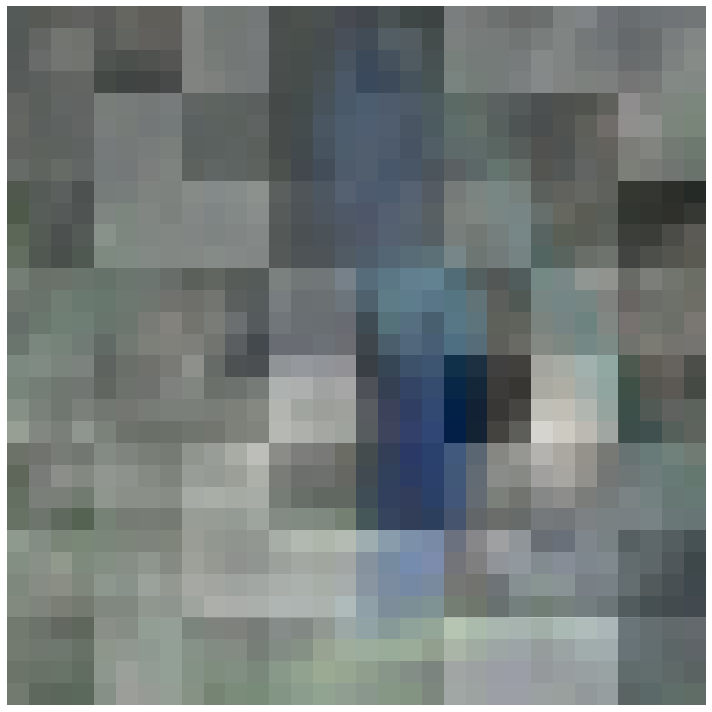

In [30]:
idx = 200

def plot_attention(image, attention_plot):
    plt.show();
    fig = plt.figure(figsize=(10, 10))

    temp_att = np.resize(attention_plot, (8, 8))
    ax = fig.add_subplot(1, 1, 1)
    img = ax.imshow(image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.axis(False)
    plt.tight_layout()

output, attention = attention_model(X_train_scaled[idx:idx+1])
plot_attention(X_train_scaled[idx], attention)

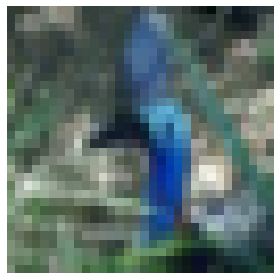

In [31]:
plt.axis(False)
plt.tight_layout()
plt.imshow(X_train_scaled[200]);